## CNN LSTM 
### Input: Mel Spectrogram-- Entire MusicNet Dataset

In [ ]:
import os
import numpy as np
import pandas as pd
import scipy.io.wavfile
import scipy.signal
import matplotlib.pyplot as plt
import keras
from random import sample 
%matplotlib inline

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LSTM, Permute
from keras.layers import TimeDistributed, Flatten, Dense, Reshape, Dropout
from keras.utils import multi_gpu_model
import tensorflow as tf

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [10]:
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [33]:
label1 = np.load('LabelFile3')
label2 = np.load('LabelFile2_20s.npz')
label3 = np.load('LabelFile3_20s.npz')

np.shape(label2['arr_0'])

allLabels = np.concatenate((label1['arr_0'],label2['arr_0'],label3['arr_0']),axis=0)


np.unique(allLabels)
dict = {'Bach':0, 'Beethoven':1, 'Brahms':2, 'Cambini':3, 'Dvorak':4, 'Faure':5, 'Haydn':6, 'Mozart': 7, 'Ravel': 8, 'Schubert': 9}
allLabelsNum = list(map(dict.get, allLabels))
# labels = allLabelsNum
labels = one_hot_encode(allLabelsNum)

In [34]:
file1 = np.load('featuresFile1_20s.npz')
file2 = np.load('featuresFile2_20s.npz')
file3 = np.load('featuresFile3_20s.npz')

In [35]:
features = np.concatenate((file1['arr_0'], file2['arr_0'],file3['arr_0']),axis=0)

In [36]:
np.shape(features)

(5652, 60, 1722, 1)

In [37]:
from sklearn.model_selection import train_test_split
import sklearn
import sklearn.linear_model
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

In [66]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [classes[i] for i in unique_labels(y_true, y_pred)]
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [40]:
# Design model
num_classes=10
# with tf.device('/cpu:0'):
model = Sequential()
model.add(Permute((2, 1,3), input_shape=(60,1722,1)))
model.add(Conv2D(16, (16, 8), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 1)))
model.add(BatchNormalization())
model.add(Dropout(.3))

model.add(Conv2D(16, (16, 8), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 1)))
model.add(BatchNormalization())
model.add(Dropout(.3))

model.add(Conv2D(16, (16, 8), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(BatchNormalization())

model.add(Reshape([43,39*16]))

model.add(LSTM(num_classes, return_sequences=True))
model.add(Dropout(.3))
model.add(LSTM(num_classes))
model.add(Dense(num_classes))
model.add(Dropout(.1))
model.add(Dense(num_classes, activation='softmax'))

 

In [41]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_5 (Permute)          (None, 1722, 60, 1)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1707, 53, 16)      2064      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 426, 53, 16)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 426, 53, 16)       64        
_________________________________________________________________
dropout_9 (Dropout)          (None, 426, 53, 16)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 411, 46, 16)       32784     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 102, 46, 16)       0         
__________

In [44]:
# model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

parallel_model = multi_gpu_model(model, gpus=4)
parallel_model.compile(loss='categorical_crossentropy',
                       metrics=['accuracy'], optimizer='adam')

In [45]:
# # Train model on dataset
# history = parallel_model.fit_generator(generator=training_generator, epochs=30,
#                     validation_data=validation_generator,
#                     use_multiprocessing=True,
#                     workers=10)

from keras.callbacks import History 
history = History()
hist = parallel_model.fit(X_train, y_train, batch_size=32, epochs=100,verbose=1, validation_data=(X_test, y_test),callbacks = [history])


Train on 3956 samples, validate on 848 samples
Epoch 1/100
3956/3956 [==============================] - 34s 8ms/step - loss: 1.5482 - acc: 0.5301 - val_loss: 1.5414 - val_acc: 0.5472
Epoch 2/100
3956/3956 [==============================] - 21s 5ms/step - loss: 1.4986 - acc: 0.5308 - val_loss: 1.6810 - val_acc: 0.5472
Epoch 3/100
3956/3956 [==============================] - 22s 6ms/step - loss: 1.4706 - acc: 0.5329 - val_loss: 1.7770 - val_acc: 0.5472
Epoch 4/100
3956/3956 [==============================] - 22s 6ms/step - loss: 1.4591 - acc: 0.5321 - val_loss: 1.5753 - val_acc: 0.5472
Epoch 5/100
3956/3956 [==============================] - 22s 6ms/step - loss: 1.4525 - acc: 0.5367 - val_loss: 1.4213 - val_acc: 0.5672
Epoch 6/100
3956/3956 [==============================] - 21s 5ms/step - loss: 1.4315 - acc: 0.5410 - val_loss: 2.0236 - val_acc: 0.0684
Epoch 7/100
3956/3956 [==============================] - 21s 5ms/step - loss: 1.4004 - acc: 0.5511 - val_loss: 1.6606 - val_acc: 0.5495
E

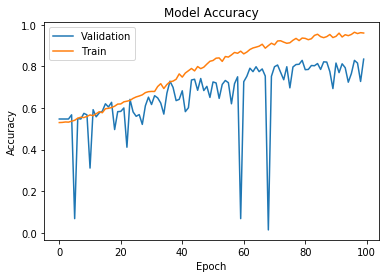

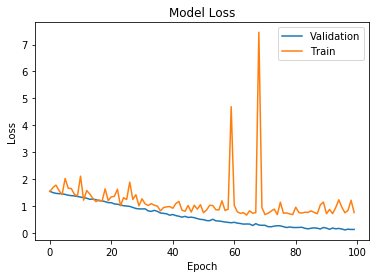

In [47]:
plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation','Train'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper right')
plt.show()

In [48]:
print(X_test.shape, y_test.shape)
# determine the classification accuracy
score, accuracy = parallel_model.evaluate(X_test, y_test)
y_pred = parallel_model.predict(X_test)
print("\nAccuracy = {:.2f}".format(accuracy))

(848, 60, 1722, 1) (848, 10)
848/848 [==============================] - 2s 3ms/step

Accuracy = 0.83


In [49]:
#y_pred = model.predict(test_x)
y_pred1 = np.argmax(y_pred, axis=1)
y_test1 = np.argmax(y_test, axis=1)
print(y_pred1.shape,y_test1.shape)

(848,) (848,)


In [50]:
unique_categories = np.unique(metadata['composer'])
unique_categories

array(['Bach', 'Beethoven', 'Brahms', 'Cambini', 'Dvorak', 'Faure',
       'Haydn', 'Mozart', 'Ravel', 'Schubert'], dtype=object)

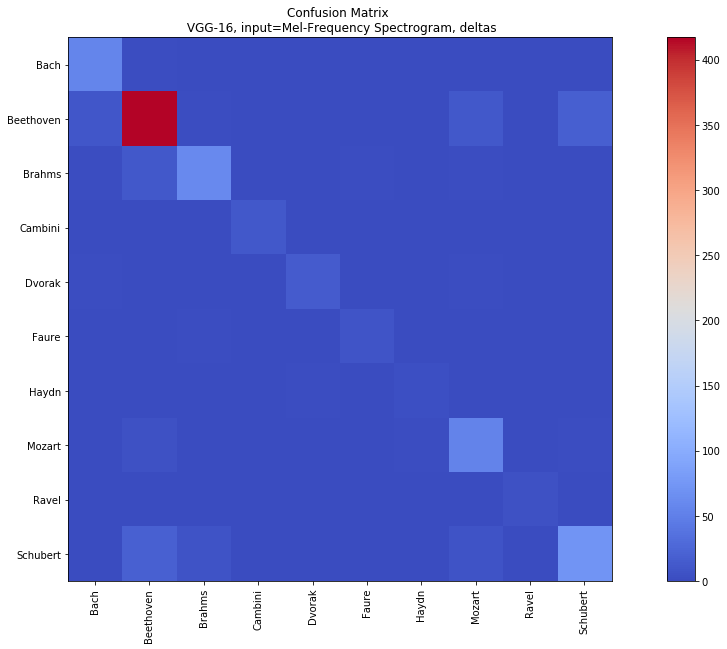

<Figure size 1440x1440 with 0 Axes>

In [51]:
#Error Analysis: Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test1, y_pred1)
# cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(20,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix \n VGG-16, input=Mel-Frequency Spectrogram, deltas')
plt.colorbar()
tick_marks = np.arange(len(unique_categories))
plt.xticks(tick_marks, unique_categories, rotation=90)
plt.yticks(tick_marks, unique_categories)
plt.figure(figsize=(20,20))
# plt.savefig('_cm.png')
plt.show()

<Figure size 1440x720 with 0 Axes>

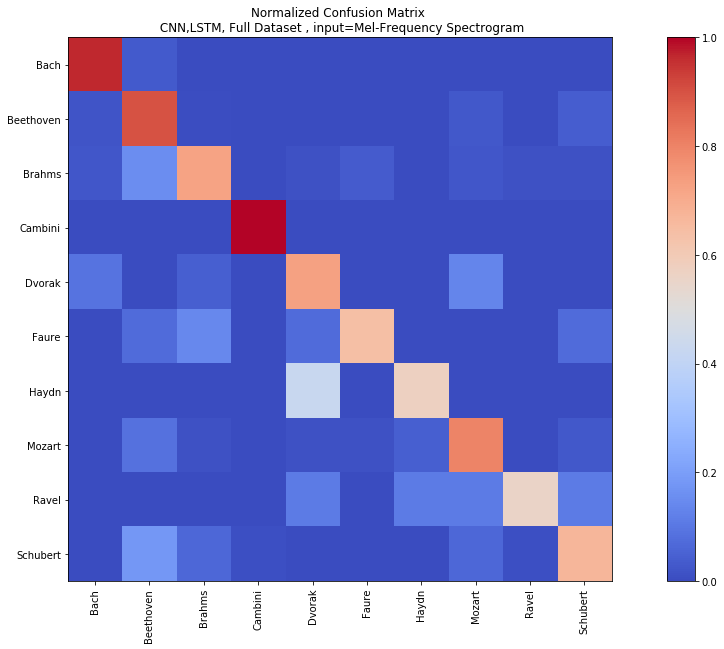

In [54]:
#Error Analysis: Confusion Matrix
plt.figure(figsize=(20,10))
cm = confusion_matrix(y_test1, y_pred1)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(20,10))
plt.imshow(cm, interpolation='nearest', cmap='coolwarm')
plt.title('Normalized Confusion Matrix \n CNN,LSTM, Full Dataset , input=Mel-Frequency Spectrogram')
plt.colorbar()
tick_marks = np.arange(len(unique_categories))
plt.xticks(tick_marks, unique_categories, rotation=90)
plt.yticks(tick_marks, unique_categories)
# plt.savefig('VGG16_input_melspec&deltas_Ncm.png')
plt.show()

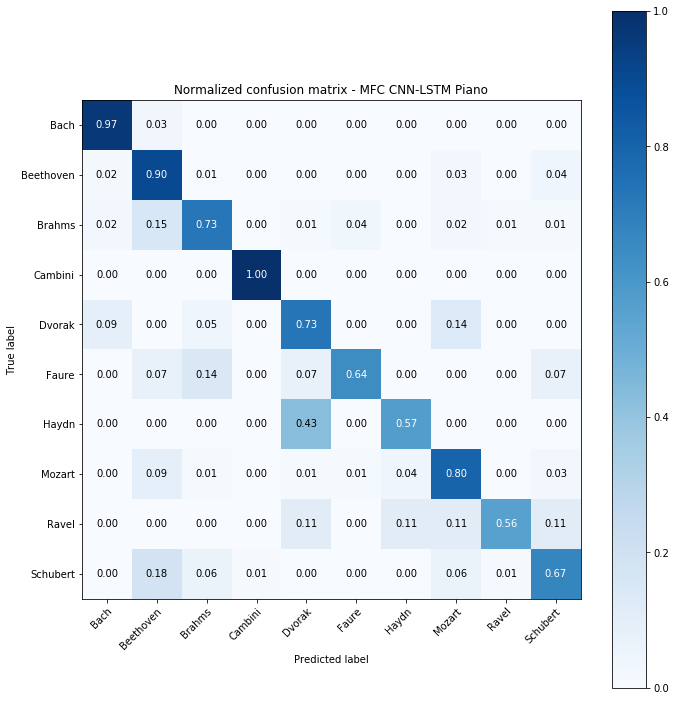

In [70]:
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(y_test1, y_pred1, classes=unique_categories,
                      title='Normalized confusion matrix - MFC CNN-LSTM ALL')

plt.show()


In [72]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score, accuracy_score, fbeta_score, classification_report
print(classification_report(y_test1,y_pred1, target_names=unique_categories))

              precision    recall  f1-score   support

        Bach       0.80      0.97      0.88        58
   Beethoven       0.91      0.90      0.90       464
      Brahms       0.81      0.73      0.77        84
     Cambini       0.86      1.00      0.92        12
      Dvorak       0.70      0.73      0.71        22
       Faure       0.69      0.64      0.67        14
       Haydn       0.50      0.57      0.53         7
      Mozart       0.68      0.80      0.73        69
       Ravel       0.62      0.56      0.59         9
    Schubert       0.75      0.67      0.71       109

   micro avg       0.83      0.83      0.83       848
   macro avg       0.73      0.76      0.74       848
weighted avg       0.84      0.83      0.83       848

